# Intent Classification in Question-Answering Using LSTM Architectures


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize


from nltk import word_tokenize,sent_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##preprocces

In [ ]:
df_QAdata = pd.read_csv('QA_data.csv', encoding='latin-1')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test.head(3)

,label-coarse,label-fine,text
0,4,40,How far is it from Denver to Aspen ?
1,5,21,"What county is Modesto , California in ?"
2,3,12,Who was Galileo ?


In [ ]:
import pandas as pd

df_QAdata["word_count"] = df_QAdata['text'].str.split().str.len()
df_QAdata["word_count_answer"] = df_QAdata['answer'].str.split().str.len()
df_train["word_count"] = df_train['text'].str.split().str.len()
df_test["word_count"] = df_test['text'].str.split().str.len()
df_test.head(3)

,label-coarse,label-fine,text,word_count
0,4,40,How far is it from Denver to Aspen ?,9
1,5,21,"What county is Modesto , California in ?",8
2,3,12,Who was Galileo ?,4


In [ ]:
df_QAdata

,label-coarse,label-fine,text,answer,word_count,word_count_answer
0,4,40,How far is it from Denver to Aspen ?,220 miles,9,2
1,5,21,"What county is Modesto , California in ?",Stanislaus,8,1
2,3,12,Who was Galileo ?,Italian scientist,4,2
3,0,7,What is an atom ?,smallest particle of an element,5,5
4,4,8,When did Hawaii become a state ?,1959,7,1
...,...,...,...,...,...,...
495,3,4,Who was the 22nd President of the US ?,Grover Cleveland,9,2
496,1,46,What is the money they use in Zambia ?,kwacha,9,1
497,4,13,How many feet in a mile ?,"5,280",7,1
498,1,28,What is the birthstone of October ?,opal,7,1


In [ ]:
# remove stop words
stop = stopwords.words('english')
df_QAdata['text'] = df_QAdata['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_QAdata['answer'] = df_QAdata['answer'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# remove punctuation else ?
regex = re.compile(f"[{re.escape(string.punctuation.replace('?', ''))}]")
df_QAdata["text"] = df_QAdata["text"].str.replace(regex, "")
df_QAdata['answer'] = df_QAdata['answer'].str.replace(regex, "")
df_train["text"] = df_train["text"].str.replace(regex, "")
df_test["text"] = df_test["text"].str.replace(regex, "")

#lowercase
df_QAdata["text"] = df_QAdata["text"].str.lower()
df_QAdata['answer'] = df_QAdata['answer'].str.lower()
df_train["text"] = df_train["text"].str.lower()
df_test["text"] = df_test["text"].str.lower()
df_test.head(3)

,label-coarse,label-fine,text,word_count
0,4,40,how far denver aspen ?,9
1,5,21,what county modesto california ?,8
2,3,12,who galileo ?,4


In [ ]:
print(df_QAdata["word_count"].max())
print(df_QAdata["word_count_answer"].max())
print(df_train["word_count"].max())
print(df_test["word_count"].max())

17
8
37
17


In [ ]:
words=df_QAdata['text']
l1=list()
for line in words:
  word_tokens=word_tokenize(line)
  l1.append(word_tokens)
df_QAdata['text_word_token']=l1

words2=df_QAdata['answer']
l2a=list()
for line in words2:
  word_tokens2=word_tokenize(line)
  l2a.append(word_tokens2)
df_QAdata['answer_word_token']=l2a

df_QAdata.head(3)

,label-coarse,label-fine,text,answer,word_count,word_count_answer,text_word_token,answer_word_token
0,4,40,how far denver aspen ?,220 miles,9,2,"[how, far, denver, aspen, ?]","[220, miles]"
1,5,21,what county modesto california ?,stanislaus,8,1,"[what, county, modesto, california, ?]",[stanislaus]
2,3,12,who galileo ?,italian scientist,4,2,"[who, galileo, ?]","[italian, scientist]"


In [ ]:
words=df_train['text']
l1=list()
for line in words:
  word_tokens=word_tokenize(line)
  l1.append(word_tokens)
df_train['word_token']=l1
df_train.head(3)

,label-coarse,label-fine,text,word_count,word_token
0,0,0,how serfdom develop leave russia ?,10,"[how, serfdom, develop, leave, russia, ?]"
1,1,1,what films featured character popeye doyle ?,8,"[what, films, featured, character, popeye, doy..."
2,0,0,how i find list celebrities real names ?,12,"[how, i, find, list, celebrities, real, names, ?]"


In [ ]:
words=df_test['text']
l1=list()
for line in words:
  word_tokens=word_tokenize(line)
  l1.append(word_tokens)
df_test['word_token']=l1
df_test.head(3)

,label-coarse,label-fine,text,word_count,word_token
0,4,40,how far denver aspen ?,9,"[how, far, denver, aspen, ?]"
1,5,21,what county modesto california ?,8,"[what, county, modesto, california, ?]"
2,3,12,who galileo ?,4,"[who, galileo, ?]"


In [ ]:
import seaborn as sns
# Calculate the length of each sentence in the column
df_QAdata["text_len"] = df_QAdata["text"].str.len()
print("max length of sentenses in QAdata = ",df_QAdata["text_len"].max())

df_QAdata["answer_len"] = df_QAdata["answer"].str.len()
print("max length of answer in QAdata = ",df_QAdata["answer_len"].max())

df_train["text_len"] = df_train["text"].str.len()
print("max length of sentenses in train = ",df_train["text_len"].max())

df_test["text_len"] = df_test["text"].str.len()
print("max length of sentenses in test = ",df_test["text_len"].max())


max length of sentenses in QAdata =  67
max length of answer in QAdata =  47
max length of sentenses in train =  139
max length of sentenses in test =  67


In [ ]:
from keras.preprocessing.text import Tokenizer

# Convert questions to sequences of word indices
tokenizer = Tokenizer() # create tokenizer
tokenizer.fit_on_texts(df_train['word_token']) # fit tokenizer on train questions
df_train['tokenized'] = tokenizer.texts_to_sequences(df_train['word_token']) # convert train questions to sequences
df_test['tokenized'] = tokenizer.texts_to_sequences(df_test['word_token']) # convert test questions to sequences

df_QAdata['tokenized_text'] = tokenizer.texts_to_sequences(df_QAdata['text_word_token'])
df_QAdata['tokenized_answer'] = tokenizer.texts_to_sequences(df_QAdata['answer_word_token'])

In [ ]:
# one-hot : label-coarse train
df_onehot = pd.get_dummies(df_train["label-coarse"].apply(pd.Series).stack()).sum(level=0)
df_onehot

<ipython-input-19-c8f965b83db8>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_onehot = pd.get_dummies(df_train["label-coarse"].apply(pd.Series).stack()).sum(level=0)


,0,1,2,3,4,5
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
5447,0,1,0,0,0,0
5448,0,1,0,0,0,0
5449,0,0,0,0,1,0
5450,0,0,0,0,1,0


In [ ]:
# one-hot : label-coarse test
df_onehotest = pd.get_dummies(df_test["label-coarse"].apply(pd.Series).stack()).sum(level=0)
df_onehotest

<ipython-input-20-6ee81b075c03>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_onehotest = pd.get_dummies(df_test["label-coarse"].apply(pd.Series).stack()).sum(level=0)


,0,1,2,3,4,5
0,0,0,0,0,1,0
1,0,0,0,0,0,1
2,0,0,0,1,0,0
3,1,0,0,0,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
495,0,0,0,1,0,0
496,0,1,0,0,0,0
497,0,0,0,0,1,0
498,0,1,0,0,0,0


In [ ]:
df_QAdata["word_count_new"] = df_QAdata['text'].str.split().str.len()
df_QAdata["answer_word_count_new"] = df_QAdata['answer'].str.split().str.len()
df_train["word_count_new"] = df_train['text'].str.split().str.len()
df_test["word_count_new"] = df_test['text'].str.split().str.len()
print(df_QAdata["word_count_new"].max())
print(df_QAdata["answer_word_count_new"].max())
print(df_train["word_count_new"].max())
print(df_test["word_count_new"].max())

11
6
20
11


## Model 1 with 25 hidden state

In [ ]:
import numpy as np
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer


In [ ]:
# load pre-trained GLOVE300 embeddings
embeddings_index = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
sequences = tokenizer.texts_to_sequences(df_train['text'])
sequencestest = tokenizer.texts_to_sequences(df_test['text'])

# pad sequences to a fixed length
maxlen = 20
padded_sequences = pad_sequences(sequences, maxlen=maxlen)
padded_sequenceste = pad_sequences(sequencestest, maxlen=maxlen)

# create an embedding matrix for the LSTM layer
num_words = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# create the LSTM model
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(25 ,return_sequences=True))
model.add(Flatten())
model.add(Dense(400))#, activation="relu"))
model.add(Dense(6, activation='softmax'))
#model.summary()
# compile the model and fit on the data
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h1 = model.fit(padded_sequences, df_onehot, epochs=50,batch_size = 32, validation_data=[padded_sequenceste,df_onehotest])

Epoch 1/50
171/171 [==============================] - 19s 62ms/step - loss: 0.9568 - accuracy: 0.6511 - val_loss: 0.7377 - val_accuracy: 0.7460
Epoch 2/50
171/171 [==============================] - 6s 34ms/step - loss: 0.5493 - accuracy: 0.8054 - val_loss: 0.6092 - val_accuracy: 0.8080
Epoch 3/50
171/171 [==============================] - 4s 21ms/step - loss: 0.4105 - accuracy: 0.8575 - val_loss: 0.5681 - val_accuracy: 0.8020
Epoch 4/50
171/171 [==============================] - 5s 28ms/step - loss: 0.3237 - accuracy: 0.8850 - val_loss: 0.5826 - val_accuracy: 0.8220
Epoch 5/50
171/171 [==============================] - 4s 21ms/step - loss: 0.2693 - accuracy: 0.9050 - val_loss: 0.5093 - val_accuracy: 0.8440
Epoch 6/50
171/171 [==============================] - 5s 28ms/step - loss: 0.1958 - accuracy: 0.9356 - val_loss: 0.5239 - val_accuracy: 0.8300
Epoch 7/50
171/171 [==============================] - 8s 47ms/step - loss: 0.1538 - accuracy: 0.9496 - val_loss: 0.5483 - val_accuracy: 0.854

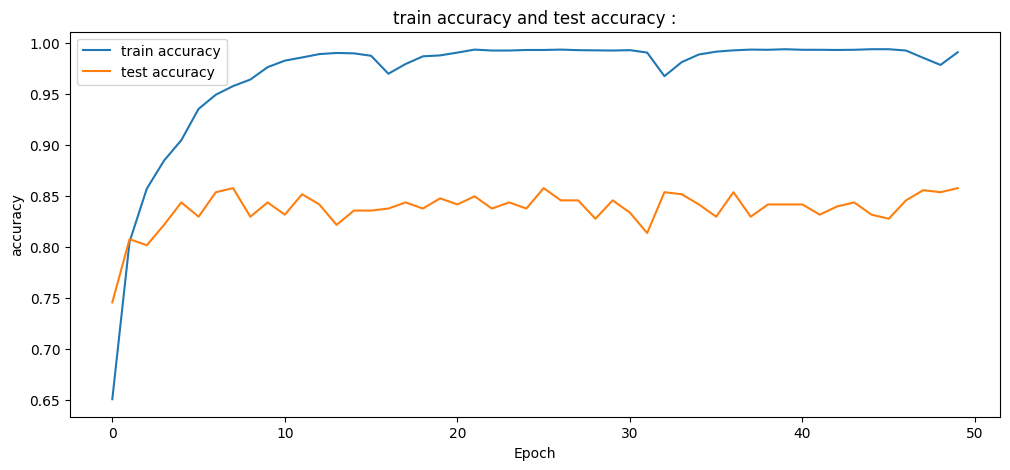

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(h1.history["accuracy"], label="train accuracy")
ax1.plot(h1.history["val_accuracy"], label="test accuracy")
plt.title("train accuracy and test accuracy :")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
ax1.legend()


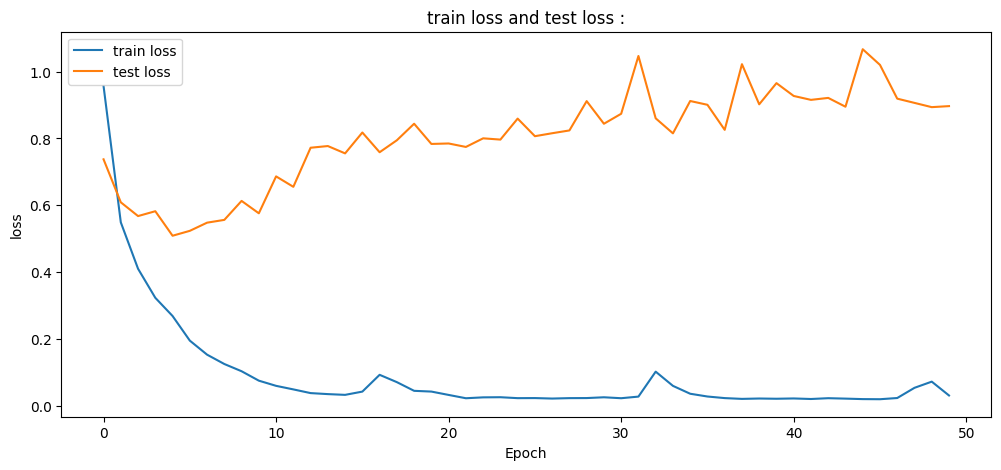

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(h1.history["loss"], label="train loss")
ax1.plot(h1.history["val_loss"], label="test loss")
plt.title("train loss and test loss :")
plt.xlabel("Epoch")
plt.ylabel("loss")
ax1.legend()

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix

y_pred = model.predict(padded_sequenceste)
y_pred = np.where(y_pred > 0.5, 1, 0)
f1 = f1_score(df_onehotest, y_pred, average='macro')
precision = precision_score(df_onehotest, y_pred, average='macro')
accuracy = accuracy_score(df_onehotest, y_pred)
recall = recall_score(df_onehotest, y_pred, average='macro')
# Print the results
print("F1-score:", f1)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("Recall:", recall)

16/16 [==============================] - 1s 7ms/step
F1-score: 0.8156932047549637
Precision: 0.858350983026923
Accuracy: 0.856
Recall: 0.793653583683255


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
cm = multilabel_confusion_matrix(df_onehotest, y_pred)
print(cm)

[[[331  31]
  [  9 129]]

 [[386  20]
  [ 24  70]]

 [[490   1]
  [  5   4]]

 [[428   7]
  [  4  61]]

 [[383   4]
  [ 20  93]]

 [[412   7]
  [ 10  71]]]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(df_onehotest, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       138
           1       0.78      0.74      0.76        94
           2       0.80      0.44      0.57         9
           3       0.90      0.94      0.92        65
           4       0.96      0.82      0.89       113
           5       0.91      0.88      0.89        81

   micro avg       0.86      0.86      0.86       500
   macro avg       0.86      0.79      0.82       500
weighted avg       0.86      0.86      0.86       500
 samples avg       0.86      0.86      0.86       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


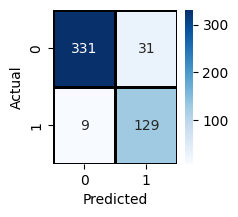

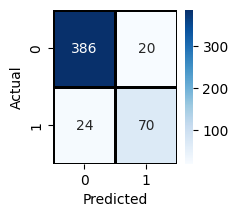

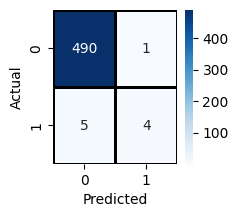

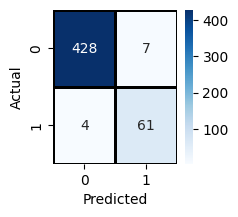

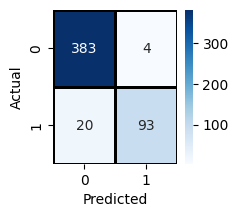

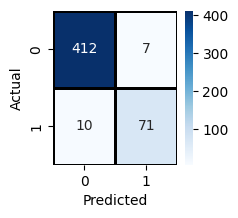

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in cm:
    #plt.imshow(cm[i], cmap='Blues')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.heatmap(i,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    #ax.set_title(f"Confusion Matrix for Class {i}")
    plt.show()

## Model 1 with 100 hidden state

In [ ]:
# model with 100 hidden state:
# create the LSTM model
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(100 ,return_sequences=True))
model.add(Flatten())
model.add(Dense(400))
model.add(Dense(6, activation='softmax'))
#model.summary()
# compile the model and fit on the data
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h2 = model.fit(padded_sequences, df_onehot, epochs=50,batch_size = 32, validation_data=[padded_sequenceste,df_onehotest])

Epoch 1/50
171/171 [==============================] - 12s 53ms/step - loss: 0.8495 - accuracy: 0.7025 - val_loss: 0.6468 - val_accuracy: 0.8040
Epoch 2/50
171/171 [==============================] - 9s 52ms/step - loss: 0.4656 - accuracy: 0.8382 - val_loss: 0.6218 - val_accuracy: 0.7760
Epoch 3/50
171/171 [==============================] - 9s 52ms/step - loss: 0.3375 - accuracy: 0.8828 - val_loss: 0.4944 - val_accuracy: 0.8320
Epoch 4/50
171/171 [==============================] - 8s 47ms/step - loss: 0.2377 - accuracy: 0.9182 - val_loss: 0.5191 - val_accuracy: 0.8260
Epoch 5/50
171/171 [==============================] - 9s 52ms/step - loss: 0.1646 - accuracy: 0.9439 - val_loss: 0.5648 - val_accuracy: 0.8360
Epoch 6/50
171/171 [==============================] - 9s 53ms/step - loss: 0.1163 - accuracy: 0.9609 - val_loss: 0.5552 - val_accuracy: 0.8480
Epoch 7/50
171/171 [==============================] - 9s 54ms/step - loss: 0.0738 - accuracy: 0.9787 - val_loss: 0.5665 - val_accuracy: 0.854

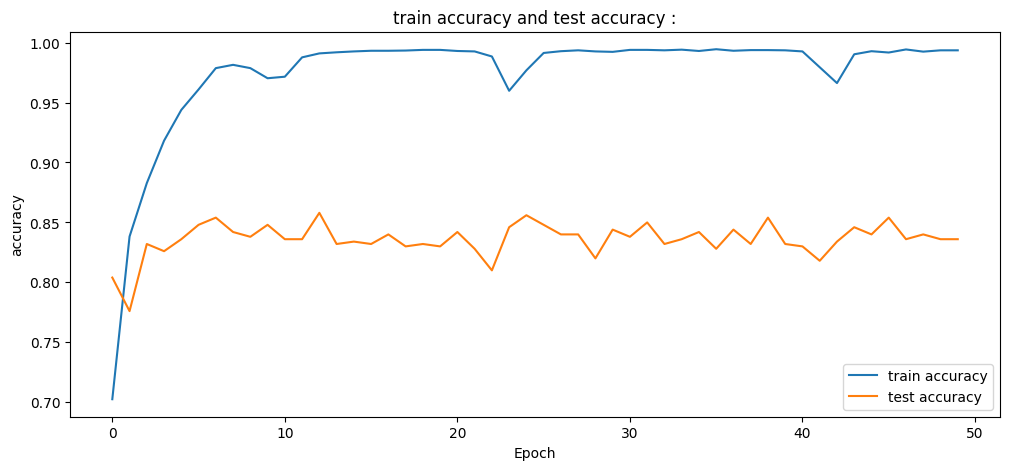

In [ ]:
fig12, ax12 = plt.subplots(figsize=(12,5))
ax12.plot(h2.history["accuracy"], label="train accuracy")
ax12.plot(h2.history["val_accuracy"], label="test accuracy")
plt.title("train accuracy and test accuracy :")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
ax12.legend()

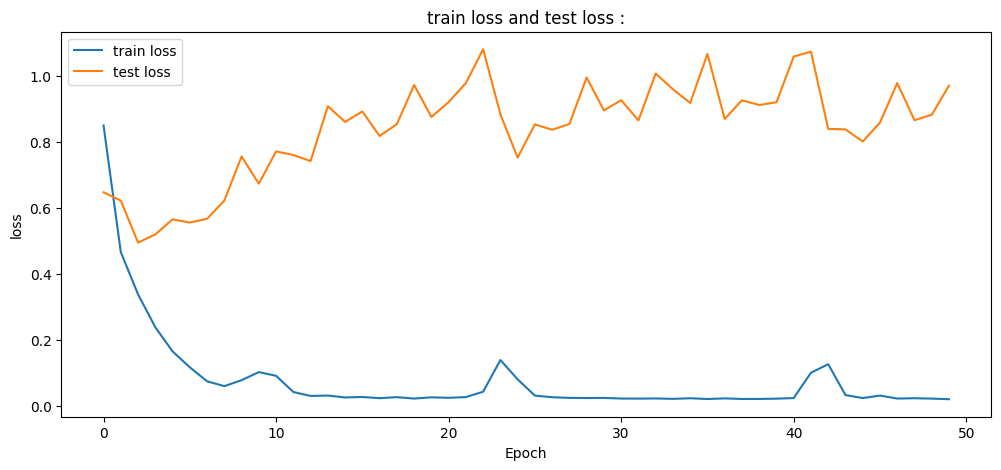

In [ ]:
fig12, ax12 = plt.subplots(figsize=(12,5))
ax12.plot(h2.history["loss"], label="train loss")
ax12.plot(h2.history["val_loss"], label="test loss")
plt.title("train loss and test loss :")
plt.xlabel("Epoch")
plt.ylabel("loss")
ax12.legend()

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix

y_pred = model.predict(padded_sequenceste)
y_pred = np.where(y_pred > 0.5, 1, 0)
f12 = f1_score(df_onehotest, y_pred, average='macro')
precision2 = precision_score(df_onehotest, y_pred, average='macro')
accuracy2 = accuracy_score(df_onehotest, y_pred)
recall2 = recall_score(df_onehotest, y_pred, average='macro')

print("F1-score:", f12)
print("Precision:", precision2)
print("Accuracy:", accuracy2)
print("Recall:", recall2)


16/16 [==============================] - 1s 16ms/step
F1-score: 0.795983799773533
Precision: 0.8507565786999597
Accuracy: 0.832
Recall: 0.766215466549383


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

cm2 = multilabel_confusion_matrix(df_onehotest, y_pred)
print(cm2)


[[[317  45]
  [  7 131]]

 [[390  16]
  [ 31  63]]

 [[490   1]
  [  5   4]]

 [[433   2]
  [ 10  55]]

 [[378   9]
  [ 20  93]]

 [[410   9]
  [ 11  70]]]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(df_onehotest, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       138
           1       0.80      0.67      0.73        94
           2       0.80      0.44      0.57         9
           3       0.96      0.85      0.90        65
           4       0.91      0.82      0.87       113
           5       0.89      0.86      0.87        81

   micro avg       0.84      0.83      0.83       500
   macro avg       0.85      0.77      0.80       500
weighted avg       0.84      0.83      0.83       500
 samples avg       0.83      0.83      0.83       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


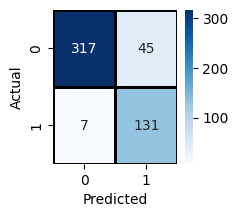

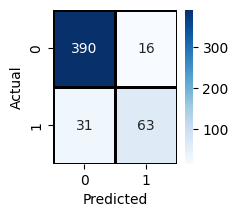

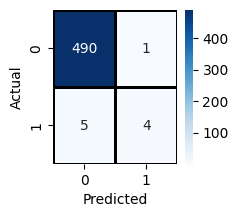

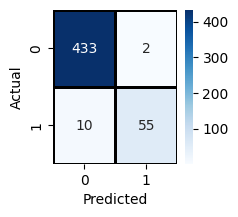

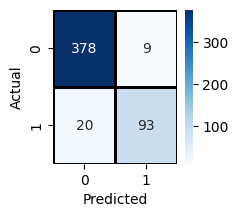

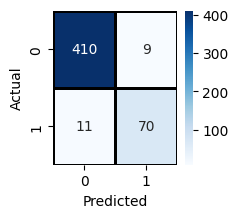

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in cm2:
    #plt.imshow(cm[i], cmap='Blues')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.heatmap(i,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    #ax.set_title(f"Confusion Matrix for Class {i}")
    plt.show()

## model 2 - 25 - label-coarse & fine:
model 2 - 25 - label-coarse

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix

In [ ]:
df_onehot_train_fine = pd.get_dummies(df_train["label-fine"].apply(pd.Series).stack()).sum(level=0)
df_onehot_train_fine

<ipython-input-40-fa5cec04e4fb>:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_onehot_train_fine = pd.get_dummies(df_train["label-fine"].apply(pd.Series).stack()).sum(level=0)


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df_test["label-fine"].unique()

array([40, 21, 12,  7,  8,  5, 30,  9,  4, 45, 14, 28, 35, 24, 41, 27, 13,
        2, 17, 11, 20, 25, 46, 18, 10,  0, 19, 26,  6, 22, 44, 37, 33, 34,
        3, 23, 38, 29, 31])

In [ ]:
df_test#2 = df_test["label-fine"]
df_test = df_test.append({"label-fine":1}, ignore_index=True)
df_test = df_test.append({"label-fine":15}, ignore_index=True)
df_test = df_test.append({"label-fine":16}, ignore_index=True)
df_test = df_test.append({"label-fine":32}, ignore_index=True)
df_test = df_test.append({"label-fine":36}, ignore_index=True)
df_test = df_test.append({"label-fine":39}, ignore_index=True)
df_test = df_test.append({"label-fine":42}, ignore_index=True)
df_test = df_test.append({"label-fine":43}, ignore_index=True)
df_test

<ipython-input-42-01d5eb1de7a1>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append({"label-fine":1}, ignore_index=True)
<ipython-input-42-01d5eb1de7a1>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append({"label-fine":15}, ignore_index=True)
<ipython-input-42-01d5eb1de7a1>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append({"label-fine":16}, ignore_index=True)
<ipython-input-42-01d5eb1de7a1>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append({"label-fine":32}, ignore_index=True)
<ipython-input-42-01d5eb1de7a1>:6: FutureWarning: The frame.append me

,label-coarse,label-fine,text,word_count,word_token,text_len,tokenized,word_count_new
0,4.0,40,how far denver aspen ?,9.0,"[how, far, denver, aspen, ?]",22.0,"[3, 321, 7197, 1]",5.0
1,5.0,21,what county modesto california ?,8.0,"[what, county, modesto, california, ?]",33.0,"[2, 307, 118, 1]",5.0
2,3.0,12,who galileo ?,4.0,"[who, galileo, ?]",13.0,"[5, 1]",3.0
3,0.0,7,what atom ?,5.0,"[what, atom, ?]",11.0,"[2, 4767, 1]",3.0
4,4.0,8,when hawaii become state ?,7.0,"[when, hawaii, become, state, ?]",26.0,"[15, 3020, 97, 23, 1]",5.0
...,...,...,...,...,...,...,...,...
503,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN
504,NaN,36,NaN,NaN,NaN,NaN,NaN,NaN
505,NaN,39,NaN,NaN,NaN,NaN,NaN,NaN
506,NaN,42,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_onehotest_test_fine = (pd.get_dummies(df_test["label-fine"].apply(pd.Series).stack()).sum(level=0)).drop(index=[500,501,502,503,504,505,506, 507])
df_onehotest_test_fine

<ipython-input-43-ecee69ffe537>:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_onehotest_test_fine = (pd.get_dummies(df_test["label-fine"].apply(pd.Series).stack()).sum(level=0)).drop(index=[500,501,502,503,504,505,506, 507])


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test = df_test.drop(507)
df_test = df_test.drop(506)
df_test = df_test.drop(505)
df_test = df_test.drop(504)
df_test = df_test.drop(503)
df_test = df_test.drop(502)
df_test = df_test.drop(501)
df_test = df_test.drop(500)
df_test

,label-coarse,label-fine,text,word_count,word_token,text_len,tokenized,word_count_new
0,4.0,40,how far denver aspen ?,9.0,"[how, far, denver, aspen, ?]",22.0,"[3, 321, 7197, 1]",5.0
1,5.0,21,what county modesto california ?,8.0,"[what, county, modesto, california, ?]",33.0,"[2, 307, 118, 1]",5.0
2,3.0,12,who galileo ?,4.0,"[who, galileo, ?]",13.0,"[5, 1]",3.0
3,0.0,7,what atom ?,5.0,"[what, atom, ?]",11.0,"[2, 4767, 1]",3.0
4,4.0,8,when hawaii become state ?,7.0,"[when, hawaii, become, state, ?]",26.0,"[15, 3020, 97, 23, 1]",5.0
...,...,...,...,...,...,...,...,...
495,3.0,4,who 22nd president us ?,9.0,"[who, 22nd, president, us, ?]",23.0,"[5, 26, 11, 1]",5.0
496,1.0,46,what money use zambia ?,9.0,"[what, money, use, zambia, ?]",23.0,"[2, 134, 84, 1]",5.0
497,4.0,13,how many feet mile ?,7.0,"[how, many, feet, mile, ?]",20.0,"[3, 6, 190, 494, 1]",5.0
498,1.0,28,what birthstone october ?,7.0,"[what, birthstone, october, ?]",25.0,"[2, 1710, 1]",4.0


In [ ]:
import keras
from keras.models import Model

sequences = tokenizer.texts_to_sequences(df_train['text'])
sequencestest = tokenizer.texts_to_sequences(df_test['text'])

# pad sequences to a fixed length
maxlen = 21
padded_sequences2 = pad_sequences(sequences, maxlen=maxlen)
padded_sequenceste2 = pad_sequences(sequencestest, maxlen=maxlen)

# create an embedding matrix for the LSTM layer
num_words = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

textss = Input(shape=(maxlen,))
embedding = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)
text_embed = embedding(textss)
LSTM_output, state_h, state_c= LSTM(25, return_state=True,return_sequences=True,)(text_embed)
f = Flatten()(state_h)
d1= Dense(400)(f)
d2=Dense(6, activation='softmax')(d1)

f = Flatten()(LSTM_output[-1])
d12= Dense(400)(f)
d22=Dense(47, activation='softmax')(d1)

model2_1 = Model(inputs=textss, outputs=d2) # Model#, answer
model2_2 = Model(inputs=textss, outputs=d22)



In [ ]:
model2_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h2_1 = model2_1.fit(padded_sequences2, df_onehot, epochs=50,batch_size = 32, validation_data=[padded_sequenceste2,df_onehotest])

Epoch 1/50
171/171 [==============================] - 7s 22ms/step - loss: 1.1058 - accuracy: 0.5680 - val_loss: 0.6490 - val_accuracy: 0.7660
Epoch 2/50
171/171 [==============================] - 3s 17ms/step - loss: 0.5986 - accuracy: 0.7867 - val_loss: 0.6040 - val_accuracy: 0.7600
Epoch 3/50
171/171 [==============================] - 3s 17ms/step - loss: 0.4450 - accuracy: 0.8424 - val_loss: 0.4438 - val_accuracy: 0.8360
Epoch 4/50
171/171 [==============================] - 4s 21ms/step - loss: 0.3535 - accuracy: 0.8769 - val_loss: 0.4423 - val_accuracy: 0.8380
Epoch 5/50
171/171 [==============================] - 3s 17ms/step - loss: 0.2919 - accuracy: 0.8997 - val_loss: 0.4261 - val_accuracy: 0.8560
Epoch 6/50
171/171 [==============================] - 3s 17ms/step - loss: 0.2347 - accuracy: 0.9160 - val_loss: 0.3856 - val_accuracy: 0.8780
Epoch 7/50
171/171 [==============================] - 3s 17ms/step - loss: 0.1941 - accuracy: 0.9338 - val_loss: 0.4211 - val_accuracy: 0.8720

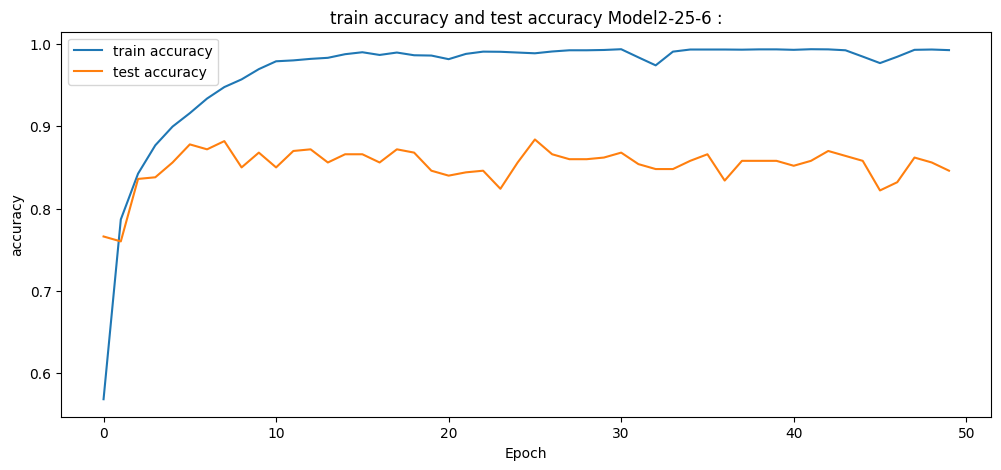

In [ ]:
fig211, ax211 = plt.subplots(figsize=(12,5))
ax211.plot(h2_1.history["accuracy"], label="train accuracy")
ax211.plot(h2_1.history["val_accuracy"], label="test accuracy")
plt.title("train accuracy and test accuracy Model2-25-6 :")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
ax211.legend()

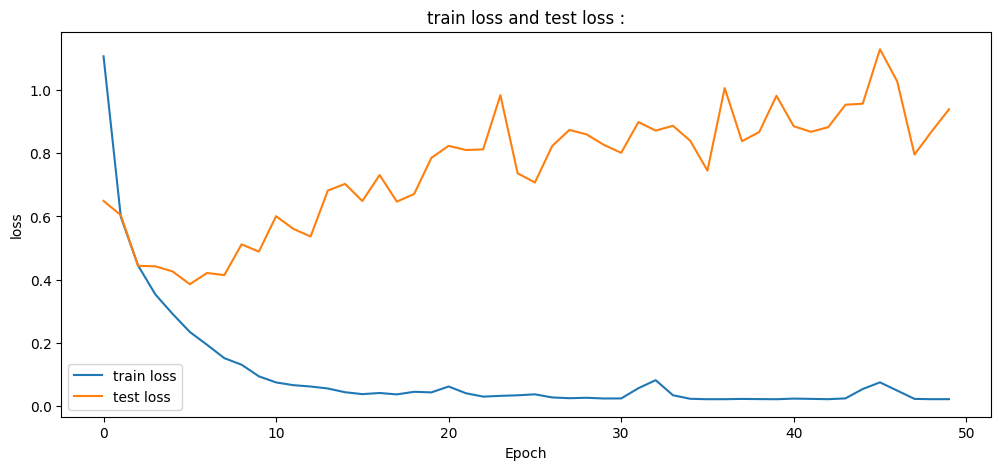

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(h2_1.history["loss"], label="train loss")
ax1.plot(h2_1.history["val_loss"], label="test loss")
plt.title("train loss and test loss :")
plt.xlabel("Epoch")
plt.ylabel("loss")
ax1.legend()

In [ ]:
y_pred = model2_1.predict(padded_sequenceste2)
y_pred = np.where(y_pred > 0.5, 1, 0)
f1 = f1_score(df_onehotest, y_pred, average='macro')
precision = precision_score(df_onehotest, y_pred, average='macro')
accuracy = accuracy_score(df_onehotest, y_pred)
recall = recall_score(df_onehotest, y_pred, average='macro')
print("F1-score:", f1)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("Recall:", recall)

16/16 [==============================] - 1s 7ms/step
F1-score: 0.8177662080285989
Precision: 0.8576448442380715
Accuracy: 0.846
Recall: 0.7942222004694205


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
cm = multilabel_confusion_matrix(df_onehotest, y_pred)
print(cm)

[[[321  41]
  [  7 131]]

 [[393  13]
  [ 32  62]]

 [[490   1]
  [  4   5]]

 [[430   5]
  [  7  58]]

 [[380   7]
  [ 12 101]]

 [[409  10]
  [ 15  66]]]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

print(classification_report(df_onehotest, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.95      0.85       138
           1       0.83      0.66      0.73        94
           2       0.83      0.56      0.67         9
           3       0.92      0.89      0.91        65
           4       0.94      0.89      0.91       113
           5       0.87      0.81      0.84        81

   micro avg       0.85      0.85      0.85       500
   macro avg       0.86      0.79      0.82       500
weighted avg       0.85      0.85      0.84       500
 samples avg       0.85      0.85      0.85       500



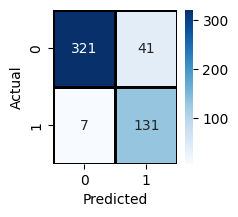

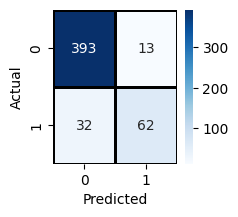

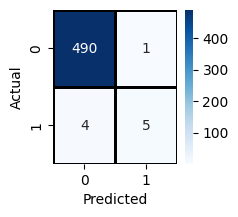

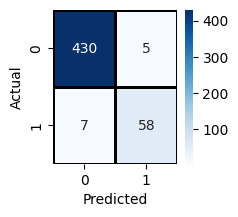

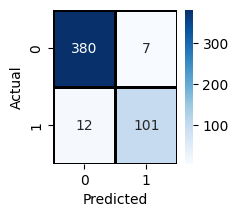

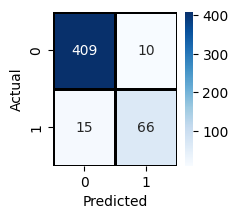

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in cm:
    #plt.imshow(cm[i], cmap='Blues')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.heatmap(i,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## model 2 - 25 - labelfine:


In [ ]:
model2_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h2_2 = model2_2.fit(padded_sequences2, df_onehot_train_fine, epochs=50,batch_size = 32, validation_data=[padded_sequenceste2,df_onehotest_test_fine])


Epoch 1/50
171/171 [==============================] - 6s 23ms/step - loss: 1.7265 - accuracy: 0.5308 - val_loss: 1.5753 - val_accuracy: 0.6180
Epoch 2/50
171/171 [==============================] - 3s 20ms/step - loss: 1.1060 - accuracy: 0.6741 - val_loss: 1.3058 - val_accuracy: 0.6740
Epoch 3/50
171/171 [==============================] - 3s 18ms/step - loss: 0.8519 - accuracy: 0.7518 - val_loss: 1.2148 - val_accuracy: 0.6940
Epoch 4/50
171/171 [==============================] - 3s 17ms/step - loss: 0.6728 - accuracy: 0.8032 - val_loss: 1.1288 - val_accuracy: 0.7320
Epoch 5/50
171/171 [==============================] - 4s 21ms/step - loss: 0.5391 - accuracy: 0.8476 - val_loss: 1.0780 - val_accuracy: 0.7600
Epoch 6/50
171/171 [==============================] - 3s 18ms/step - loss: 0.4425 - accuracy: 0.8744 - val_loss: 1.1698 - val_accuracy: 0.7300
Epoch 7/50
171/171 [==============================] - 3s 17ms/step - loss: 0.3653 - accuracy: 0.8999 - val_loss: 1.1716 - val_accuracy: 0.7300

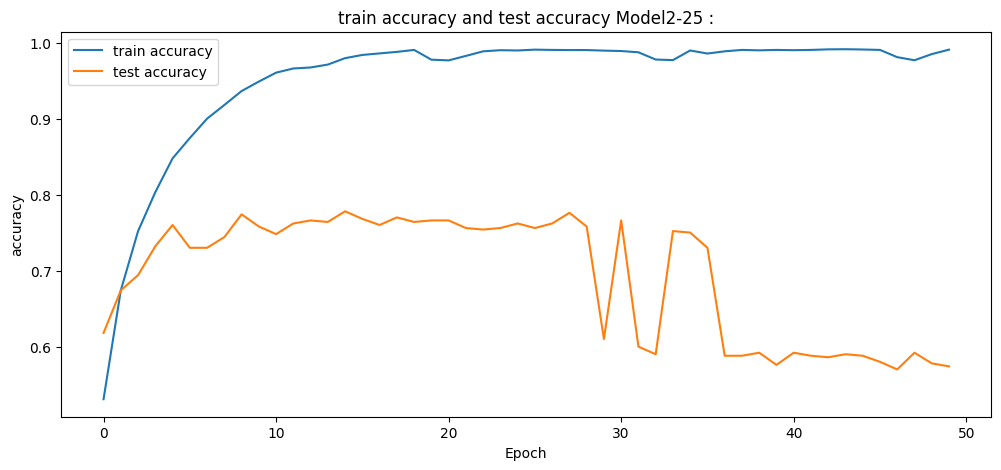

In [ ]:
fig21, ax21 = plt.subplots(figsize=(12,5))
ax21.plot(h2_2.history["accuracy"], label="train accuracy")
ax21.plot(h2_2.history["val_accuracy"], label="test accuracy")
plt.title("train accuracy and test accuracy Model2-25 :")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
ax21.legend()

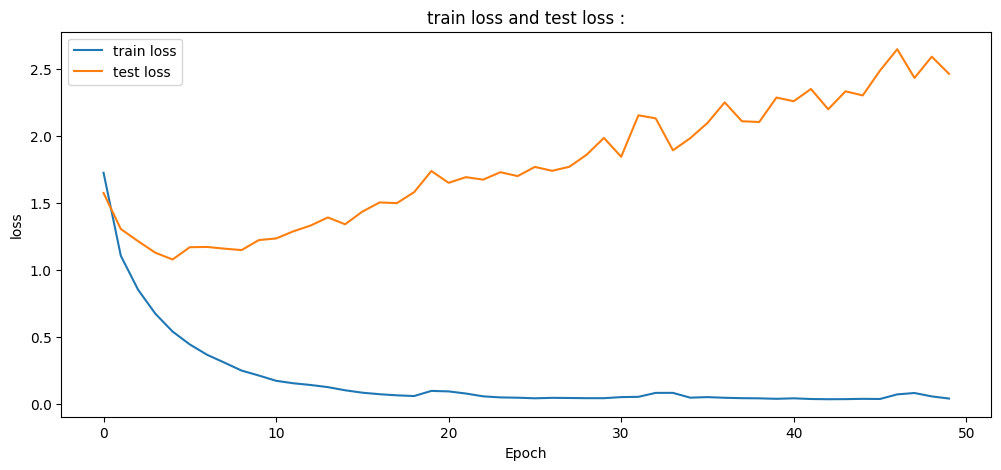

In [ ]:
fig12, ax12 = plt.subplots(figsize=(12,5))
ax12.plot(h2_2.history["loss"], label="train loss")
ax12.plot(h2_2.history["val_loss"], label="test loss")
plt.title("train loss and test loss :")
plt.xlabel("Epoch")
plt.ylabel("loss")
ax12.legend()

In [ ]:
y_pred = model2_2.predict(padded_sequenceste2)
y_pred = np.where(y_pred > 0.5, 1, 0)
f1 = f1_score(df_onehotest_test_fine, y_pred, average='macro')
precision = precision_score(df_onehotest_test_fine, y_pred, average='macro')
accuracy = accuracy_score(df_onehotest_test_fine, y_pred)
recall = recall_score(df_onehotest_test_fine, y_pred, average='macro')
print("F1-score:", f1)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("Recall:", recall)

16/16 [==============================] - 1s 6ms/step
F1-score: 0.3980048418690197
Precision: 0.4479738215693163
Accuracy: 0.568
Recall: 0.4023437861219001


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
cm = multilabel_confusion_matrix(df_onehotest_test_fine, y_pred)
print(cm)

[[[497   1]
  [  0   2]]

 [[498   2]
  [  0   0]]

 [[484   0]
  [ 10   6]]

 [[491   1]
  [  4   4]]

 [[437   8]
  [  4  51]]

 [[491   3]
  [  4   2]]

 [[499   0]
  [  1   0]]

 [[344  33]
  [ 88  35]]

 [[445   8]
  [  3  44]]

 [[489   5]
  [  1   5]]

 [[498   0]
  [  2   0]]

 [[489   4]
  [  4   3]]

 [[404  86]
  [  4   6]]

 [[485   6]
  [  1   8]]

 [[405  21]
  [ 25  49]]

 [[500   0]
  [  0   0]]

 [[500   0]
  [  0   0]]

 [[494   2]
  [  1   3]]

 [[495   2]
  [  0   3]]

 [[490   0]
  [  5   5]]

 [[487   6]
  [  3   4]]

 [[481   1]
  [  4  14]]

 [[498   0]
  [  2   0]]

 [[494   4]
  [  2   0]]

 [[494   3]
  [  3   0]]

 [[494   3]
  [  1   2]]

 [[496   0]
  [  4   0]]

 [[492   0]
  [  3   5]]

 [[483   2]
  [ 10   5]]

 [[499   0]
  [  0   1]]

 [[495   0]
  [  3   2]]

 [[498   1]
  [  1   0]]

 [[500   0]
  [  0   0]]

 [[499   0]
  [  1   0]]

 [[499   0]
  [  1   0]]

 [[494   0]
  [  4   2]]

 [[500   0]
  [  0   0]]

 [[498   0]
  [  0   2]]

 [[497   0]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(df_onehotest_test_fine, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         0
           2       1.00      0.38      0.55        16
           3       0.80      0.50      0.62         8
           4       0.86      0.93      0.89        55
           5       0.40      0.33      0.36         6
           6       0.00      0.00      0.00         1
           7       0.51      0.28      0.37       123
           8       0.85      0.94      0.89        47
           9       0.50      0.83      0.62         6
          10       0.00      0.00      0.00         2
          11       0.43      0.43      0.43         7
          12       0.07      0.60      0.12        10
          13       0.57      0.89      0.70         9
          14       0.70      0.66      0.68        74
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.60    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


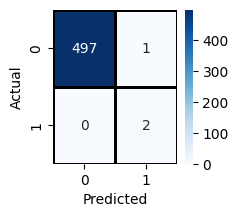

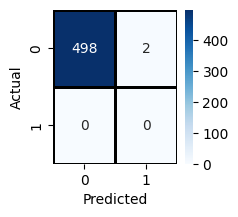

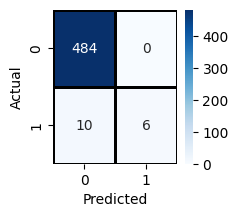

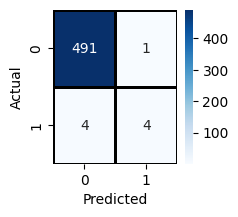

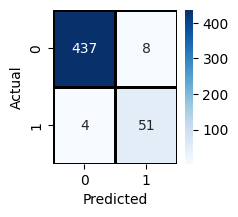

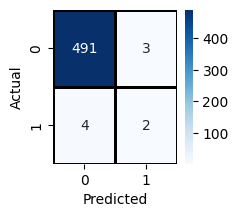

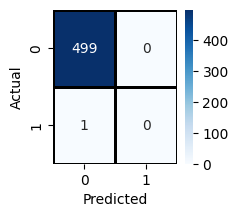

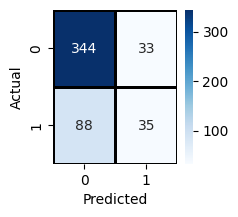

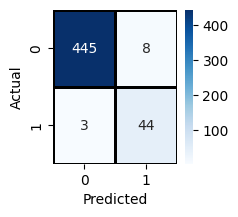

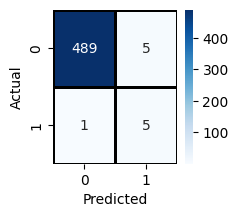

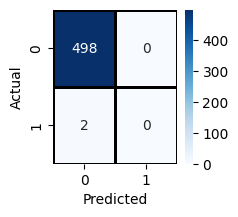

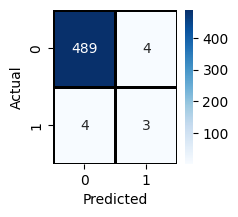

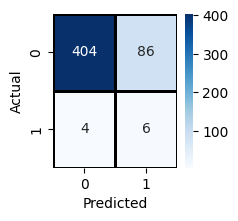

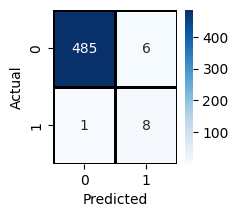

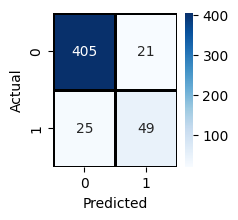

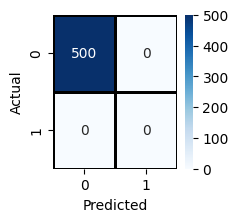

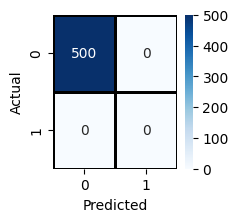

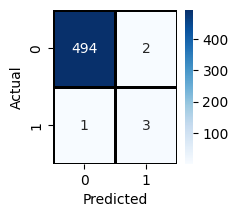

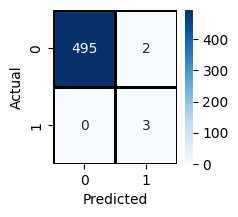

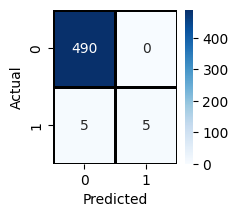

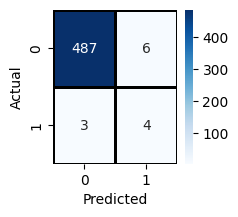

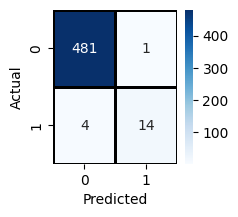

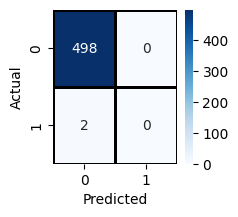

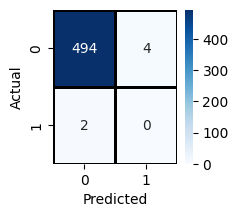

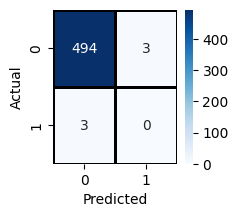

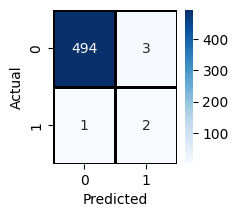

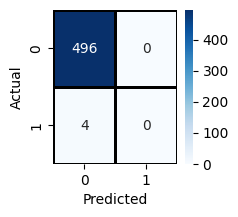

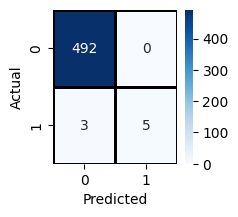

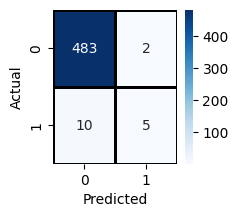

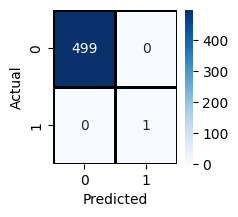

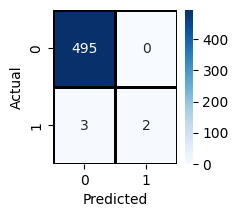

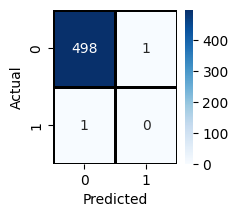

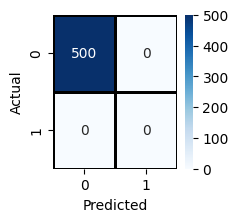

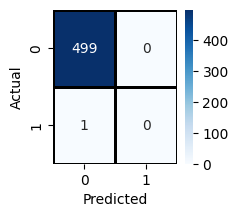

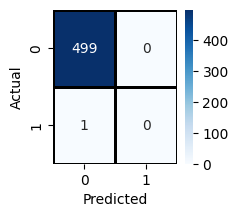

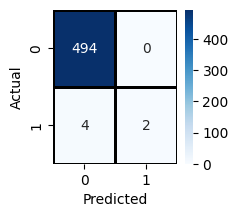

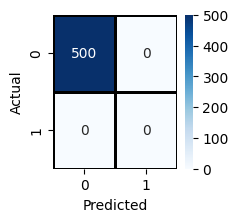

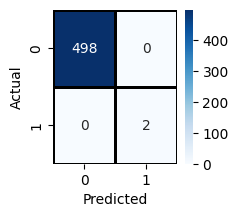

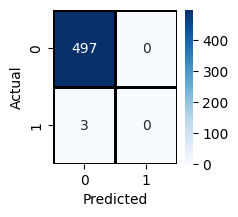

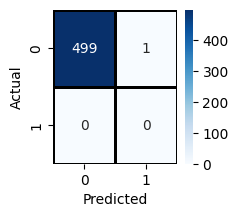

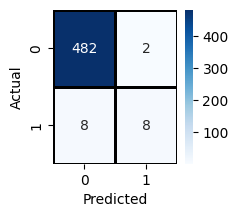

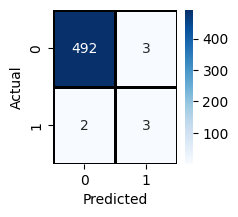

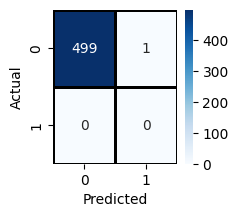

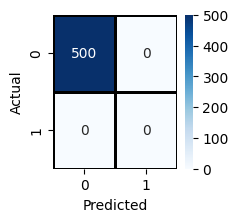

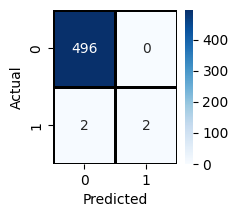

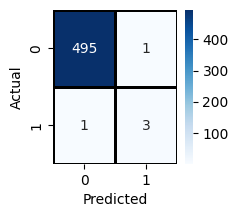

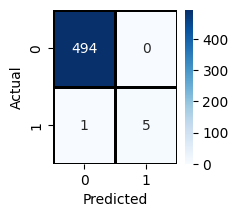

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in cm:
    #plt.imshow(cm[i], cmap='Blues')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.heatmap(i,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## model 2 - 100 - label-coarse & fine:
model 2 - 100 - label-coarse

In [ ]:
import keras
sequences = tokenizer.texts_to_sequences(df_train['text'])
sequencestest = tokenizer.texts_to_sequences(df_test['text'])

# pad sequences to a fixed length
maxlen = 21
padded_sequences2 = pad_sequences(sequences, maxlen=maxlen)
padded_sequenceste2 = pad_sequences(sequencestest, maxlen=maxlen)

# create an embedding matrix for the LSTM layer
num_words = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

textss = Input(shape=(maxlen,))
embedding = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)
text_embed = embedding(textss)
otlstmm= LSTM(100, return_state=True,return_sequences=True,)(text_embed)
LSTM_output, state_h, state_c =otlstmm
f = Flatten()(state_h)
d1= Dense(400)(f)
d2=Dense(6, activation='softmax')(d1)

f = Flatten()(LSTM_output[-1])
d12= Dense(400)(f)
d22=Dense(47, activation='softmax')(d1)

model2_25_1 = Model(inputs=textss, outputs=d2)
model2_25_2 = Model(inputs=textss, outputs=d22)

In [ ]:
model2_25_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h2_25_1 = model2_25_1.fit(padded_sequences2, df_onehot, epochs=50,batch_size = 32, validation_data=[padded_sequenceste2,df_onehotest])

Epoch 1/50
171/171 [==============================] - 10s 42ms/step - loss: 0.8907 - accuracy: 0.6737 - val_loss: 0.6298 - val_accuracy: 0.7900
Epoch 2/50
171/171 [==============================] - 7s 44ms/step - loss: 0.5213 - accuracy: 0.8153 - val_loss: 0.5894 - val_accuracy: 0.7760
Epoch 3/50
171/171 [==============================] - 6s 38ms/step - loss: 0.3696 - accuracy: 0.8678 - val_loss: 0.4400 - val_accuracy: 0.8460
Epoch 4/50
171/171 [==============================] - 7s 43ms/step - loss: 0.2812 - accuracy: 0.9006 - val_loss: 0.5060 - val_accuracy: 0.8400
Epoch 5/50
171/171 [==============================] - 7s 44ms/step - loss: 0.2102 - accuracy: 0.9261 - val_loss: 0.4185 - val_accuracy: 0.8440
Epoch 6/50
171/171 [==============================] - 6s 37ms/step - loss: 0.1475 - accuracy: 0.9474 - val_loss: 0.5450 - val_accuracy: 0.8540
Epoch 7/50
171/171 [==============================] - 7s 43ms/step - loss: 0.1128 - accuracy: 0.9628 - val_loss: 0.5167 - val_accuracy: 0.862

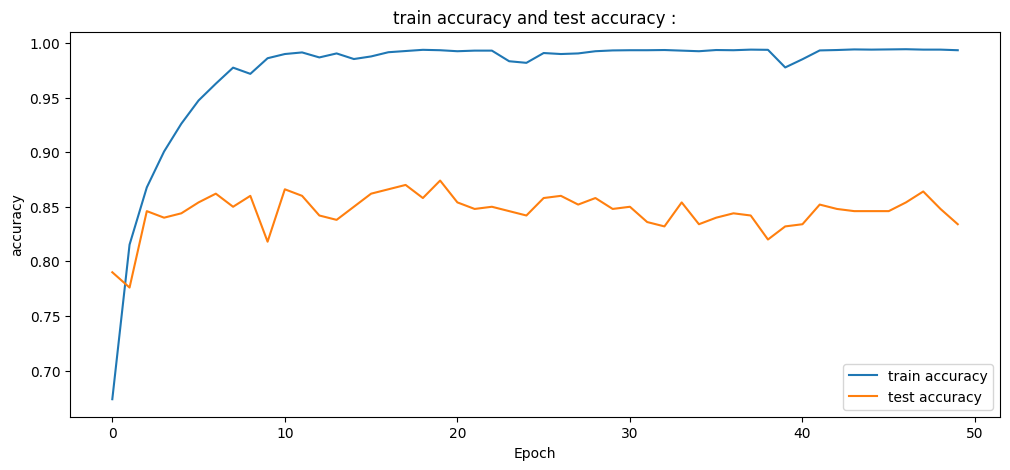

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(h2_25_1.history["accuracy"], label="train accuracy")
ax1.plot(h2_25_1.history["val_accuracy"], label="test accuracy")
plt.title("train accuracy and test accuracy :")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
ax1.legend()

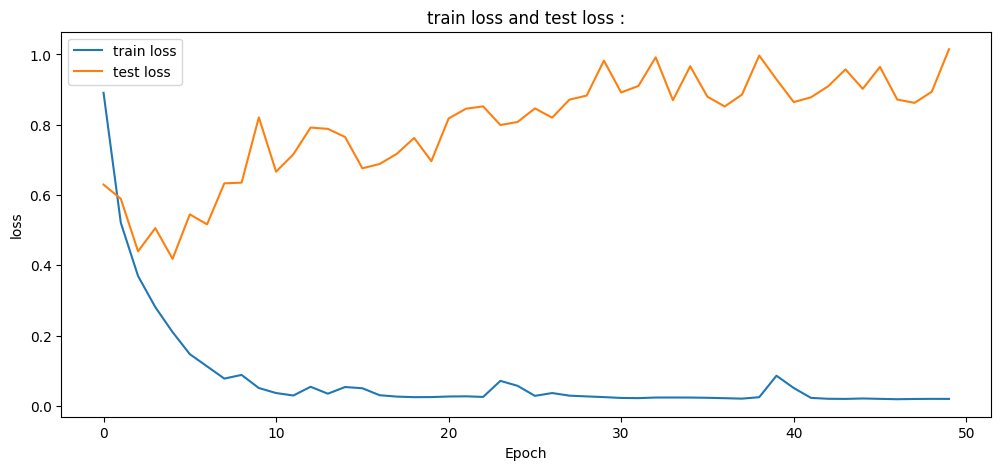

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(h2_25_1.history["loss"], label="train loss")
ax1.plot(h2_25_1.history["val_loss"], label="test loss")
plt.title("train loss and test loss :")
plt.xlabel("Epoch")
plt.ylabel("loss")
ax1.legend()

In [ ]:
y_pred = model2_25_1.predict(padded_sequenceste2)
y_pred = np.where(y_pred > 0.5, 1, 0)
f1 = f1_score(df_onehotest, y_pred, average='macro')
precision = precision_score(df_onehotest, y_pred, average='macro')
accuracy = accuracy_score(df_onehotest, y_pred)
recall = recall_score(df_onehotest, y_pred, average='macro')
print("F1-score:", f1)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("Recall:", recall)

16/16 [==============================] - 1s 16ms/step
F1-score: 0.8182051572258935
Precision: 0.8832584751650763
Accuracy: 0.828
Recall: 0.7831850475884777


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
cm = multilabel_confusion_matrix(df_onehotest, y_pred)
print(cm)

[[[314  48]
  [  8 130]]

 [[391  15]
  [ 31  63]]

 [[491   0]
  [  4   5]]

 [[430   5]
  [  6  59]]

 [[378   9]
  [ 23  90]]

 [[414   5]
  [ 14  67]]]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(df_onehotest, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       138
           1       0.81      0.67      0.73        94
           2       1.00      0.56      0.71         9
           3       0.92      0.91      0.91        65
           4       0.91      0.80      0.85       113
           5       0.93      0.83      0.88        81

   micro avg       0.83      0.83      0.83       500
   macro avg       0.88      0.78      0.82       500
weighted avg       0.85      0.83      0.83       500
 samples avg       0.83      0.83      0.83       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


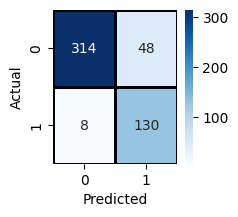

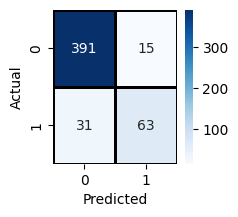

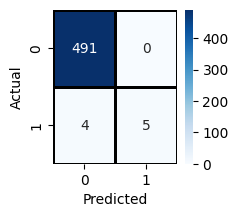

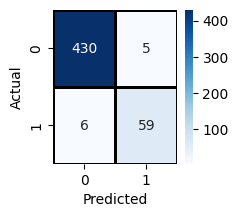

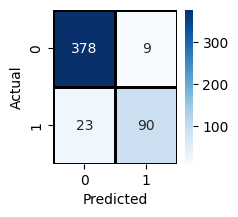

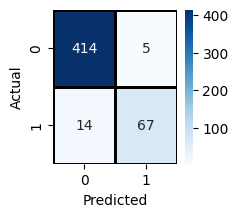

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in cm:
    #plt.imshow(cm[i], cmap='Blues')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.heatmap(i,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    #ax.set_title(f"Confusion Matrix for Class {i}")
    plt.show()

## model 2 - 100 - label fine:

In [ ]:
model2_25_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h2_25_2 = model2_25_2.fit(padded_sequences2, df_onehot_train_fine, epochs=50,batch_size = 32, validation_data=[padded_sequenceste2,df_onehotest_test_fine])

Epoch 1/50
171/171 [==============================] - 10s 42ms/step - loss: 1.4174 - accuracy: 0.6075 - val_loss: 1.3118 - val_accuracy: 0.6900
Epoch 2/50
171/171 [==============================] - 8s 44ms/step - loss: 0.6395 - accuracy: 0.8175 - val_loss: 1.1655 - val_accuracy: 0.7280
Epoch 3/50
171/171 [==============================] - 7s 44ms/step - loss: 0.3793 - accuracy: 0.8947 - val_loss: 1.0308 - val_accuracy: 0.7340
Epoch 4/50
171/171 [==============================] - 7s 39ms/step - loss: 0.2309 - accuracy: 0.9406 - val_loss: 1.0017 - val_accuracy: 0.7660
Epoch 5/50
171/171 [==============================] - 7s 44ms/step - loss: 0.1448 - accuracy: 0.9655 - val_loss: 0.9872 - val_accuracy: 0.7740
Epoch 6/50
171/171 [==============================] - 7s 39ms/step - loss: 0.0962 - accuracy: 0.9763 - val_loss: 1.0610 - val_accuracy: 0.7760
Epoch 7/50
171/171 [==============================] - 8s 45ms/step - loss: 0.0660 - accuracy: 0.9853 - val_loss: 1.0730 - val_accuracy: 0.768

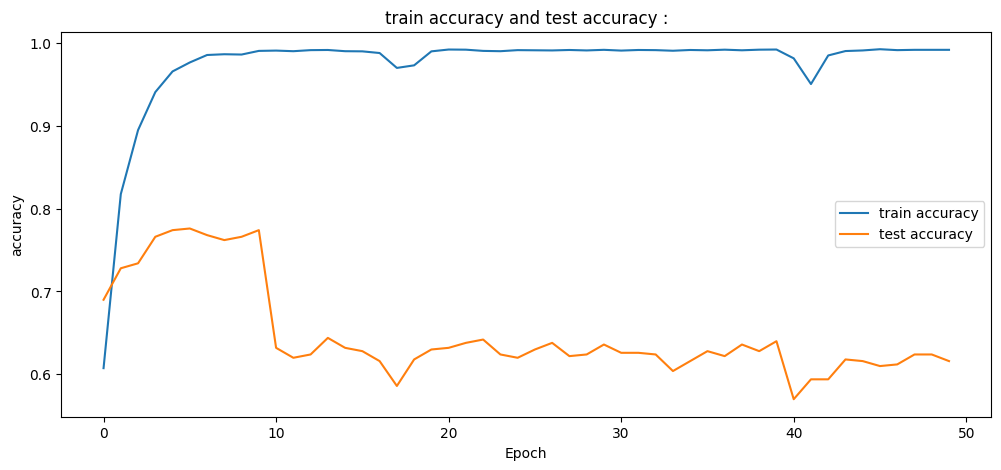

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(h2_25_2.history["accuracy"], label="train accuracy")
ax1.plot(h2_25_2.history["val_accuracy"], label="test accuracy")
plt.title("train accuracy and test accuracy :")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
ax1.legend()

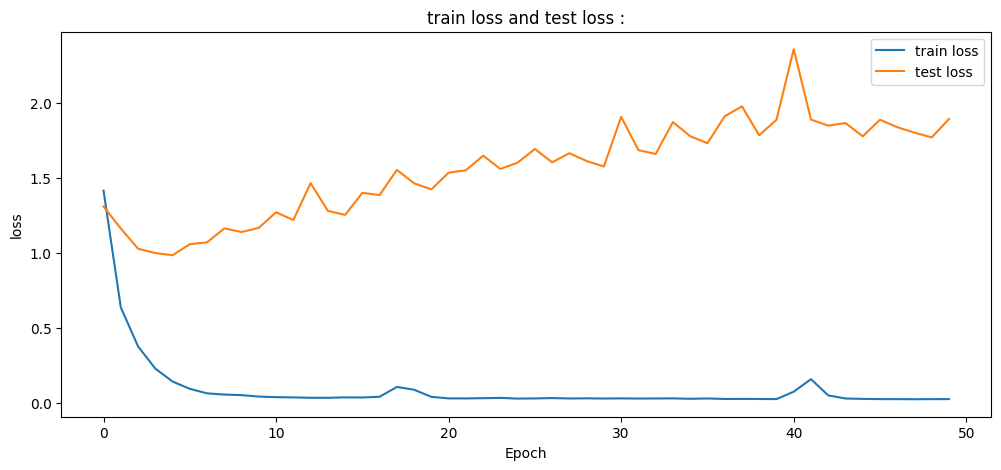

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(h2_25_2.history["loss"], label="train loss")
ax1.plot(h2_25_2.history["val_loss"], label="test loss")
plt.title("train loss and test loss :")
plt.xlabel("Epoch")
plt.ylabel("loss")
ax1.legend()

In [ ]:
y_pred = model2_25_2.predict(padded_sequenceste2)
y_pred = np.where(y_pred > 0.5, 1, 0)
f1 = f1_score(df_onehotest_test_fine, y_pred, average='macro')
precision = precision_score(df_onehotest_test_fine, y_pred, average='macro')
accuracy = accuracy_score(df_onehotest_test_fine, y_pred)
recall = recall_score(df_onehotest_test_fine, y_pred, average='macro')
print("F1-score:", f1)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("Recall:", recall)

16/16 [==============================] - 1s 14ms/step
F1-score: 0.5480683899816913
Precision: 0.6010911732473592
Accuracy: 0.612
Recall: 0.5482030229937902


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
cm = multilabel_confusion_matrix(df_onehotest_test_fine, y_pred)
print(cm)

[[[497   1]
  [  0   2]]

 [[499   1]
  [  0   0]]

 [[483   1]
  [  5  11]]

 [[491   1]
  [  4   4]]

 [[440   5]
  [  6  49]]

 [[489   5]
  [  2   4]]

 [[499   0]
  [  1   0]]

 [[347  30]
  [ 90  33]]

 [[452   1]
  [  1  46]]

 [[492   2]
  [  0   6]]

 [[497   1]
  [  1   1]]

 [[489   4]
  [  4   3]]

 [[401  89]
  [  3   7]]

 [[487   4]
  [  0   9]]

 [[406  20]
  [ 26  48]]

 [[500   0]
  [  0   0]]

 [[500   0]
  [  0   0]]

 [[496   0]
  [  2   2]]

 [[496   1]
  [  0   3]]

 [[490   0]
  [  3   7]]

 [[489   4]
  [  2   5]]

 [[481   1]
  [  4  14]]

 [[498   0]
  [  0   2]]

 [[497   1]
  [  1   1]]

 [[497   0]
  [  0   3]]

 [[495   2]
  [  1   2]]

 [[496   0]
  [  4   0]]

 [[491   1]
  [  1   7]]

 [[483   2]
  [ 11   4]]

 [[499   0]
  [  0   1]]

 [[495   0]
  [  3   2]]

 [[499   0]
  [  0   1]]

 [[500   0]
  [  0   0]]

 [[499   0]
  [  0   1]]

 [[499   0]
  [  1   0]]

 [[494   0]
  [  3   3]]

 [[500   0]
  [  0   0]]

 [[498   0]
  [  0   2]]

 [[495   2]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(df_onehotest_test_fine, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         0
           2       0.92      0.69      0.79        16
           3       0.80      0.50      0.62         8
           4       0.91      0.89      0.90        55
           5       0.44      0.67      0.53         6
           6       0.00      0.00      0.00         1
           7       0.52      0.27      0.35       123
           8       0.98      0.98      0.98        47
           9       0.75      1.00      0.86         6
          10       0.50      0.50      0.50         2
          11       0.43      0.43      0.43         7
          12       0.07      0.70      0.13        10
          13       0.69      1.00      0.82         9
          14       0.71      0.65      0.68        74
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


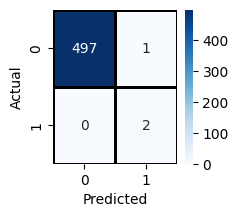

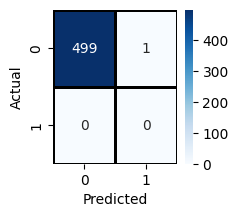

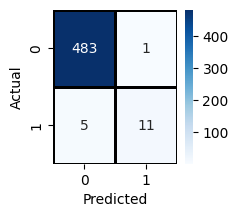

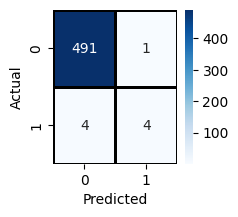

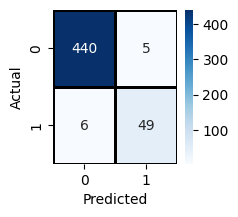

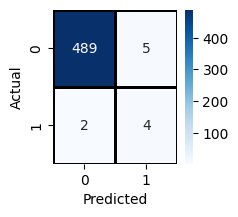

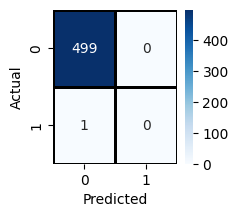

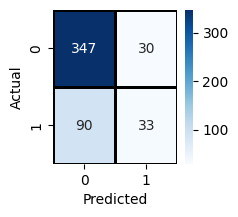

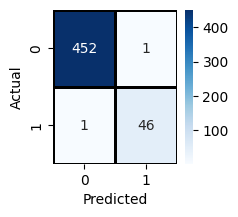

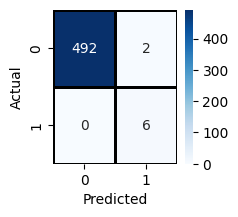

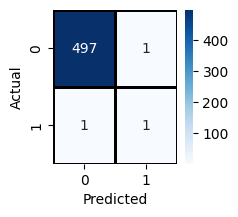

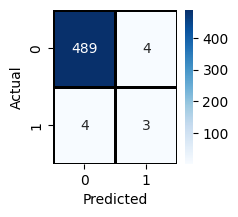

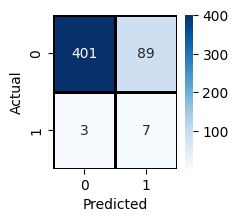

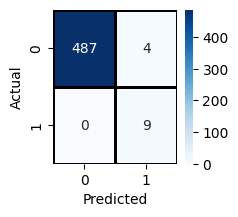

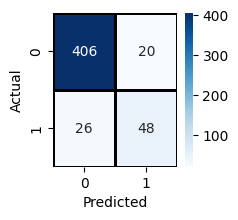

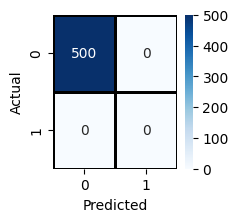

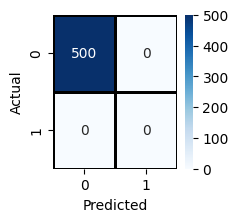

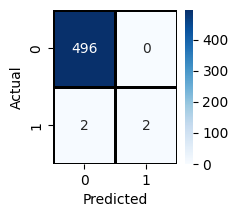

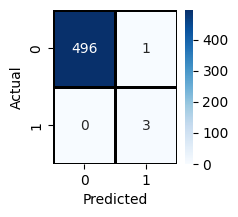

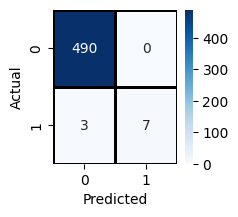

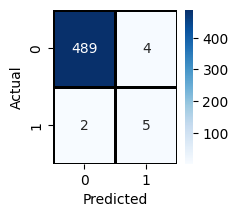

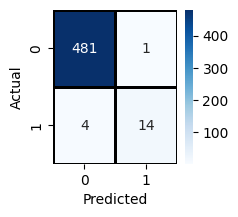

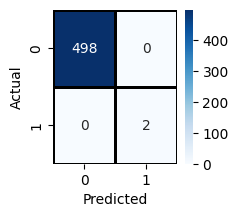

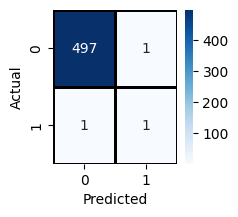

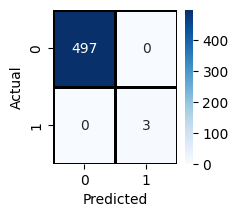

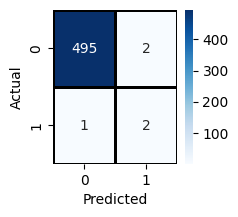

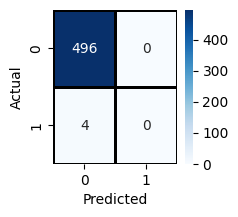

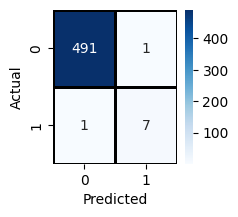

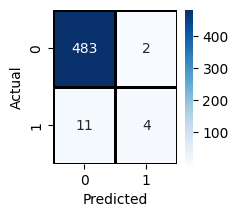

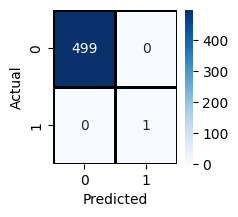

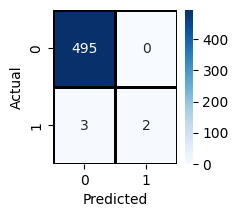

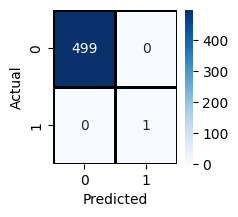

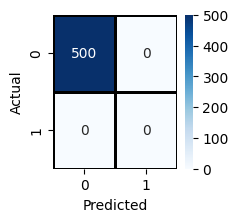

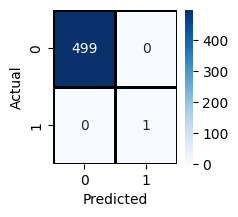

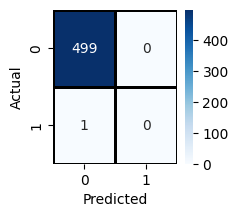

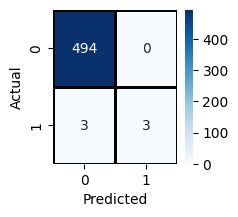

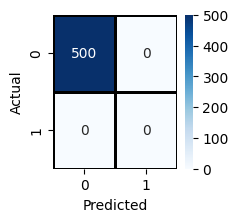

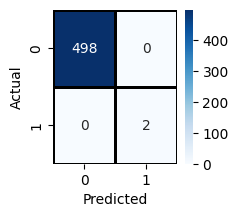

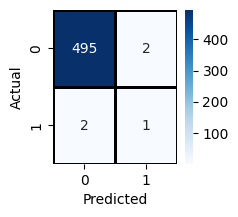

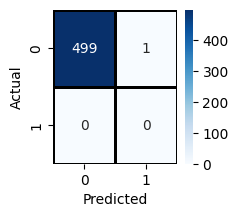

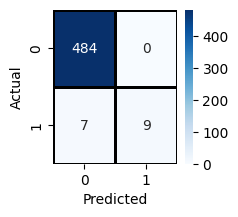

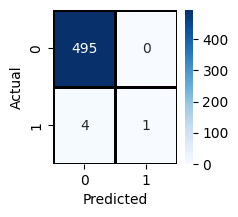

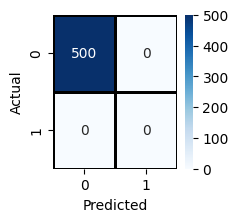

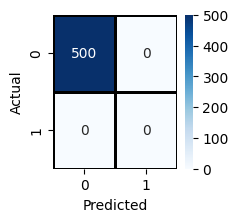

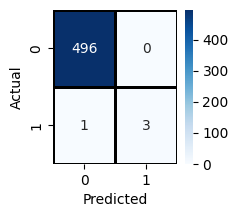

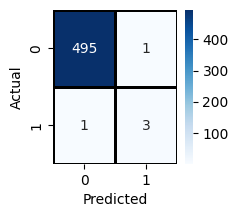

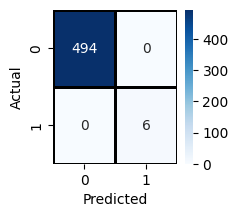

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in cm:
    #plt.imshow(cm[i], cmap='Blues')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.heatmap(i,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    #ax.set_title(f"Confusion Matrix for Class {i}")
    plt.show()

## Model3 QA

In [ ]:
import keras
sequences = tokenizer.texts_to_sequences(df_QAdata['text'])
sequencesanswer = tokenizer.texts_to_sequences(df_QAdata['answer'])

# pad sequences to a fixed length
maxlen = 12
maxlenanswer = 7
padded_sequences = pad_sequences(sequences, maxlen=maxlen)
padded_sequencesanswer = pad_sequences(sequencesanswer, maxlen=maxlenanswer)
question = Input(shape=(12,))
answer = Input(shape=(7,))
label = Input(shape=(7,))
# create an embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)

question_embed = embedding(question) # Question embedding
answer_embed = embedding(answer)

bidirectional_layer = Bidirectional(LSTM(units=100, return_sequences=True))
output_tensor = bidirectional_layer([question_embed,answer_embed], initial_state=[state_h, state_c, state_h, state_c])

f = Flatten()(output_tensor)
output = Dense(7, activation='softmax')(f)

model3 = Model(inputs=[question, answer], outputs=output) #

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compile model

haq3 = model3.fit([padded_sequences, padded_sequencesanswer],padded_sequencesanswer, epochs=50, batch_size=32)

Epoch 1/50
16/16 [==============================] - 6s 50ms/step - loss: 1771.7379 - accuracy: 0.6820
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 2693.9158 - accuracy: 0.7800
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 5182.5776 - accuracy: 0.7800
Epoch 4/50
16/16 [==============================] - 2s 96ms/step - loss: 6576.3208 - accuracy: 0.7800
Epoch 5/50
16/16 [==============================] - 2s 94ms/step - loss: 8316.6885 - accuracy: 0.7800
Epoch 6/50
16/16 [==============================] - 1s 49ms/step - loss: 9834.9580 - accuracy: 0.7800
Epoch 7/50
16/16 [==============================] - 1s 48ms/step - loss: 11259.7793 - accuracy: 0.7800
Epoch 8/50
16/16 [==============================] - 1s 48ms/step - loss: 12441.2803 - accuracy: 0.7800
Epoch 9/50
16/16 [==============================] - 1s 51ms/step - loss: 13803.0332 - accuracy: 0.7800
Epoch 10/50
16/16 [==============================] - 1s 48ms/step - loss: 15009

In [ ]:
new_question = "How many people speak French ?" # example question
new_question_sequence = tokenizer.texts_to_sequences([new_question]) # convert question to sequence of integers
new_question_padded = tf.keras.preprocessing.sequence.pad_sequences(new_question_sequence, maxlen=maxlen) # pad question sequence
prediction = model.predict([new_question_padded, new_question_padded]) # predict answer probabilities using model
prediction_class = prediction.argmax(axis=-1)[0] # get the class with the highest probability
prediction_answer = tokenizer.index_word[prediction_class] # get the word corresponding to the class index
print(f"The predicted answer is: {prediction_answer}") # print the predicted answer

1/1 [==============================] - 0s 32ms/step
The predicted answer is: sos


In [ ]:
new_question = "What day is today  ?" # example question
new_question_sequence = tokenizer.texts_to_sequences([new_question]) # convert question to sequence of integers
new_question_padded = tf.keras.preprocessing.sequence.pad_sequences(new_question_sequence, maxlen=maxlen) # pad question sequence
prediction = model.predict([new_question_padded, new_question_padded]) # predict answer probabilities using model
prediction_class = prediction.argmax(axis=-1)[0] # get the class with the highest probability
prediction_answer = tokenizer.index_word[prediction_class] # get the word corresponding to the class index
print(f"The predicted answer is: {prediction_answer}") # print the predicted answer

1/1 [==============================] - 0s 34ms/step
The predicted answer is: salk


In [ ]:
new_question = "Who will win the war ?" # example question
new_question_sequence = tokenizer.texts_to_sequences([new_question]) # convert question to sequence of integers
new_question_padded = tf.keras.preprocessing.sequence.pad_sequences(new_question_sequence, maxlen=maxlen) # pad question sequence
prediction = model.predict([new_question_padded, new_question_padded]) # predict answer probabilities using model
prediction_class = prediction.argmax(axis=-1)[0] # get the class with the highest probability
prediction_answer = tokenizer.index_word[prediction_class] # get the word corresponding to the class index
print(f"The predicted answer is: {prediction_answer}") # print the predicted answer

1/1 [==============================] - 0s 29ms/step
The predicted answer is: restores


In [ ]:
new_question = "Who is Italian first minister ?" # example question
new_question_sequence = tokenizer.texts_to_sequences([new_question]) # convert question to sequence of integers
new_question_padded = tf.keras.preprocessing.sequence.pad_sequences(new_question_sequence, maxlen=maxlen) # pad question sequence
prediction = model.predict([new_question_padded, new_question_padded]) # predict answer probabilities using model
prediction_class = prediction.argmax(axis=-1)[0] # get the class with the highest probability
prediction_answer = tokenizer.index_word[prediction_class] # get the word corresponding to the class index
print(f"The predicted answer is: {prediction_answer}") # print the predicted answer

1/1 [==============================] - 0s 36ms/step
The predicted answer is: zimbabwe


In [ ]:
new_question = "When World War II ended ?" # example question
new_question_sequence = tokenizer.texts_to_sequences([new_question]) # convert question to sequence of integers
new_question_padded = tf.keras.preprocessing.sequence.pad_sequences(new_question_sequence, maxlen=maxlen) # pad question sequence
prediction = model.predict([new_question_padded, new_question_padded]) # predict answer probabilities using model
prediction_class = prediction.argmax(axis=-1)[0] # get the class with the highest probability
prediction_answer = tokenizer.index_word[prediction_class] # get the word corresponding to the class index
print(f"The predicted answer is: {prediction_answer}") # print the predicted answer

1/1 [==============================] - 0s 41ms/step
The predicted answer is: county


In [ ]:
new_question = "When Gandhi was assassinated ?" # example question
new_question_sequence = tokenizer.texts_to_sequences([new_question]) # convert question to sequence of integers
new_question_padded = tf.keras.preprocessing.sequence.pad_sequences(new_question_sequence, maxlen=maxlen) # pad question sequence
prediction = model.predict([new_question_padded, new_question_padded]) # predict answer probabilities using model
prediction_class = prediction.argmax(axis=-1)[0] # get the class with the highest probability
prediction_answer = tokenizer.index_word[prediction_class] # get the word corresponding to the class index
print(f"The predicted answer is: {prediction_answer}") # print the predicted answer

1/1 [==============================] - 0s 37ms/step
The predicted answer is: salk


##-------------------------------------------------------------------------------------------------------------------------------------------------------------